## imdb dataset

In [1]:
%matplotlib inline
import collections
import re
import os
import nltk
import random
import matplotlib
import matplotlib.pyplot as plt

def get_sent_in_directory(path_directory):
    sents = []
    for filename in os.listdir(path_directory):
        if os.path.isfile(os.path.join(path_directory, filename)):
            with open(os.path.join(path_directory, filename), 'r') as f:
                for line in f:
                    sents.append(nltk.tokenize.word_tokenize(line))
    return sents
                    
                
train_pos = get_sent_in_directory("./aclImdb/train/pos")
train_neg = get_sent_in_directory("./aclImdb/train/neg")
test_pos = get_sent_in_directory("./aclImdb/test/pos")
test_neg = get_sent_in_directory("./aclImdb/test/neg")
unlabeled_data = get_sent_in_directory("./aclImdb/train/unsup")

print("len(train_pos)", len(train_pos))
print("len(train_neg)", len(train_neg))
print("len(test_pos)", len(test_pos))
print("len(test_neg)", len(test_neg))
print("len(unlabeled_data)", len(unlabeled_data))
print("train_pos[0]", train_pos[0])

len(train_pos) 12500
len(train_neg) 12500
len(test_pos) 12500
len(test_neg) 12500
len(unlabeled_data) 50000
train_pos[0] ['``', 'The', 'Last', 'Hard', 'Men', "''", 'is', 'a', 'typical', 'western', 'for', 'the', '70', "'s", '.', 'Most', 'of', 'them', 'seem', 'to', 'be', 'inspired', 'by', 'Sam', 'Peckinpah', '.', 'Also', 'this', 'one', ',', 'but', 'Director', 'Andrew', 'McLaglan', 'is', 'a', 'John', 'Ford', 'Pupil', 'and', 'this', 'can', 'be', 'obviously', 'shown', 'in', 'many', 'scenes', '.', 'IMO', 'the', 'beginning', 'is', 'very', 'good', '.', 'In', 'a', 'certain', 'way', 'McLaglan', 'wanted', 'to', 'show', 'the', 'audience', 'a', 'travel', 'from', 'the', 'civilization', 'to', 'the', 'wilderness', '.', 'In', 'the', 'third', 'part', 'there', 'are', 'some', 'illogical', 'flaws', 'and', 'I', 'complain', 'a', 'bit', 'about', 'Charlton', 'Heston', '.', 'He', 'has', 'to', 'play', 'an', 'old', 'ex-lawman', 'named', 'Sam', 'Burgade', 'but', 'he', 'is', 'in', 'a', 'fantastic', 'physical', 'sha

unique word: 251952
# of sents: 25000
max len(sents[i]): 2502


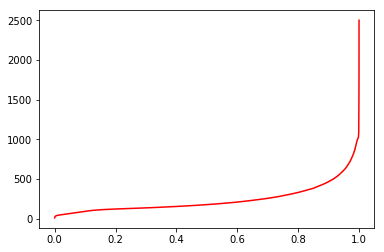

'\nt = None\nfor x in corpus_counter.most_common(60000):\n    t = x\nprint("x", x)\n'

In [2]:
corpus_counter = collections.Counter()
train_preprocess = []
test_preprocess = []
unlabeled_preprocess = []
for sent in train_pos:
    res = []
    for word in sent:
        if re.search('[a-zA-Z]', word):
            corpus_counter[word.lower()] += 1
            res.append(word.lower())
    train_preprocess.append((res, 1))
for sent in train_neg:
    res = []
    for word in sent:
        if re.search('[a-zA-Z]', word):
            corpus_counter[word.lower()] += 1
            res.append(word.lower())
    train_preprocess.append((res, 0))
for sent in test_pos:
    res = []
    for word in sent:
        if re.search('[a-zA-Z]', word):
            corpus_counter[word.lower()] += 1
            res.append(word.lower())
    test_preprocess.append((res, 1))
for sent in test_neg:
    res = []
    for word in sent:
        if re.search('[a-zA-Z]', word):
            corpus_counter[word.lower()] += 1
            res.append(word.lower())
    test_preprocess.append((res, 0))
for sent in unlabeled_data:
    res = []
    for word in sent:
        if re.search('[a-zA-Z]', word):
            corpus_counter[word.lower()] += 1
            res.append(word.lower())
    unlabeled_preprocess.append(res)

print("unique word:", len(corpus_counter))
print("# of sents:", len(train_preprocess))
print("max len(sents[i]):", max([len(s) for s, _ in train_preprocess]))

train_length = []
for sent, label in train_preprocess:
    train_length.append(len(sent))
train_length = sorted(train_length)
stat_x, stat_y = [], []
for i, l in enumerate(train_length):
    stat_x.append(i / len(train_length))
    stat_y.append(l)
plt.plot(stat_x, stat_y, 'r-')
plt.show()
"""
t = None
for x in corpus_counter.most_common(60000):
    t = x
print("x", x)
"""

## Use Brown Corpus to train an seq2seq autoencoder 

In [3]:
import tensorflow as tf
import numpy as np
import random

random.seed(1337)

class EncoderDecoder:
    def __init__(self, vocabulary={}, label={}, state_size=64, n_max_length=30):     
        self.state_size = state_size
        self.n_max_length = n_max_length
        self.vocabulary = vocabulary
        self.label = label
        self.reverse_vocabulary = {k: v for k, v in vocabulary.items()}
        
        ######################
        # Graph Construction #
        ######################
        self.graph = tf.Graph()
        with self.graph.as_default():
            #self.sen_en = tf.placeholder(tf.int32, shape=(None, self.n_max_length), name="sen_en")
            #self.sen_de = tf.placeholder(tf.int32, shape=(None, self.n_max_length), name="sen_de")
            self.sen_en = tf.placeholder(tf.int32, shape=(None, None), name="sen_en")
            self.sen_de = tf.placeholder(tf.int32, shape=(None, None), name="sen_de")
            self.sen_en_length = tf.placeholder(tf.int32, shape=(None,), name="sen_en_length")
            self.sen_de_length = tf.placeholder(tf.int32, shape=(None,), name="sen_de_length")
            self.sen_en_label = tf.placeholder(tf.int32, shape=(None,), name="sen_en_label")
                        
            batch_size_en = tf.shape(self.sen_en)[0]
            batch_size_de = tf.shape(self.sen_de)[0]
            batch_max_length_de = tf.shape(self.sen_de)[1]
            
            # TODO sen_en_embedding could also be self-trained embedding: embedding_lookup
            self.embedding = tf.Variable(tf.random_uniform([len(self.vocabulary), self.state_size], -1.0, 1.0), dtype=tf.float32)
            #self.sen_en_embedding = tf.one_hot(self.sen_en, len(self.vocabulary))
            #self.sen_de_embedding = tf.one_hot(self.sen_de, len(self.vocabulary))
            self.sen_en_embedding = tf.nn.embedding_lookup(self.embedding, self.sen_en)
            self.sen_de_embedding = tf.nn.embedding_lookup(self.embedding, self.sen_de)
            
            # build encoder decoder structure
            with tf.variable_scope("encoder") as scope:
                self.cell_en = tf.contrib.rnn.BasicLSTMCell(self.state_size)
            with tf.variable_scope("decoder") as scope:
                self.cell_de = tf.contrib.rnn.BasicLSTMCell(self.state_size)
            with tf.variable_scope("encoder") as scope:
                self.cell_en_init = self.cell_en.zero_state(batch_size_en, tf.float32)
                self.h_state_en, self.final_state_en = tf.nn.dynamic_rnn(
                    self.cell_en,
                    self.sen_en_embedding,
                    sequence_length=self.sen_en_length,
                    initial_state=self.cell_en_init,
                )
            with tf.variable_scope("decoder") as scope:
                self.cell_de_init = self.final_state_en
                self.h_state_de, self.final_state_de = tf.nn.dynamic_rnn(
                    self.cell_de,
                    self.sen_en_embedding,
                    sequence_length=self.sen_en_length,
                    initial_state=self.cell_de_init,
                )
            
            # autoencoder softmax
            with tf.variable_scope("softmax") as scope:
                W = tf.get_variable("W", [self.state_size, len(self.vocabulary)], initializer=tf.random_normal_initializer(seed=None))
                b = tf.get_variable("b", [len(self.vocabulary)], initializer=tf.random_normal_initializer(seed=None))               
            self.logits = tf.reshape(
                tf.add(tf.matmul(tf.reshape(self.h_state_de, (-1, self.state_size)), W), b),
                shape=(-1, batch_max_length_de, len(self.vocabulary))
            )
            self.pred_sa = tf.nn.softmax(self.logits)
                
            # construct loss and train op
            self.cross_ent = tf.nn.sparse_softmax_cross_entropy_with_logits(
                labels=self.sen_de,
                logits=self.logits
            )        
            self.mask = tf.sequence_mask(self.sen_de_length, maxlen=batch_max_length_de)
            self.loss_sa = tf.reduce_mean(
                tf.divide(
                    tf.reduce_sum(
                        tf.where(
                            self.mask,
                            self.cross_ent,
                            tf.zeros_like(self.cross_ent)
                        ), 1
                    ),
                    tf.to_float(self.sen_de_length)
                )
            )
            
            # classifier layer
            with tf.variable_scope("classifier") as scope:
                clf_input = tf.concat([self.final_state_en.h, self.final_state_en.c], axis=1)
                clf_dense = tf.layers.dense(clf_input, 30, activation=tf.nn.relu)
                self.clf_output = tf.layers.dense(clf_dense, len(self.label))
            
            self.pred_clf = tf.nn.softmax(self.clf_output)
                   
            # construct classifier loss
            self.loss_clf = tf.reduce_sum(
                tf.nn.sparse_softmax_cross_entropy_with_logits(
                    labels=self.sen_en_label,
                    logits=self.clf_output,
                )
            )        
            
            # Optimization
            optimizer = tf.train.AdamOptimizer()
            self.op_train_sa = optimizer.minimize(self.loss_sa)
            self.op_train_clf = optimizer.minimize(self.loss_clf)
               
            # initializer
            gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.2)
            self.sess = tf.Session(
                graph=self.graph,
                config=tf.ConfigProto(gpu_options=gpu_options)
            )           
            self.init = tf.global_variables_initializer()
            self.sess.run(self.init)
            
    def train_sa(self, batch_sen_en, batch_sen_de, batch_sen_en_length, batch_sen_de_length):
        """
        Parameters
        ----------
        batch_sen_en: numpy, shape=(n, max_length), dtype=int
        batch_sen_de: numpy, shape=(n, max_length), dtype=int
        batch_sen_en_length: numpy, shape=(n,), dtype=int
        batch_sen_de_length: numpy, shape=(n,), dtype=int
        """
        assert batch_sen_en.shape[0] == batch_sen_de.shape[0]
        assert batch_sen_en.shape[1] == self.n_max_length  # training always input same length as self.n_max_length
        _, loss, pred, sen_en_embedding, mask, cross_ent = self.sess.run(
            [self.op_train_sa, self.loss_sa, self.pred_sa, self.sen_en_embedding, self.mask, self.cross_ent],
            feed_dict={
                self.sen_en: batch_sen_en,
                self.sen_de: batch_sen_de,
                self.sen_en_length: batch_sen_en_length,
                self.sen_de_length: batch_sen_de_length,
            }
        )
        return loss, pred, sen_en_embedding, mask, cross_ent
        
    def predict_sa(self, batch_sen_en, batch_sen_de, batch_sen_en_length, batch_sen_de_length):
        """
        Parameters
        ----------
        batch_sen_en: numpy, shape=(n, max_length), dtype=int
        batch_sen_de: numpy, shape=(n, max_length), dtype=int
        batch_sen_en_length: numpy, shape=(n,), dtype=int
        batch_sen_de_length: numpy, shape=(n,), dtype=int
        """
        assert batch_sen_en.shape[0] == batch_sen_de.shape[0]
        loss, pred = self.sess.run(
            [self.loss_sa, self.pred_sa],
            feed_dict={
                self.sen_en: batch_sen_en,
                self.sen_de: batch_sen_de,
                self.sen_en_length: batch_sen_en_length,
                self.sen_de_length: batch_sen_de_length,
            }
        )
        return loss, pred
    
    def encode_sa(self, batch_sen_en, batch_sen_en_length):
        """
        Parameters
        ----------
        batch_sen_en: numpy, shape=(n, max_length), dtype=int
        batch_sen_en_length: numpy, shape=(n,), dtype=int
        Returns
        -------
        #batch_state_en: numpy, shape=(n, self.state_size), dtype=float
        batch_state_en: LSTMStateTuple
        """
        batch_state_en = self.sess.run(
            self.final_state_en,
            feed_dict={
                self.sen_en: batch_sen_en,
                self.sen_en_length: batch_sen_en_length,
            }
        )
        return batch_state_en
    
    def decode_sa(self, batch_state_en):
        """
        Parameters
        ----------
        batch_state_en: LSTMStateTuple
        Returns
        -------
        batch_sen_de: numpy, shape=(n, max_length), dtype=int
        """
        batch_size = batch_state_en.c.shape[0]
        batch_sen_de = np.empty([batch_size, self.n_max_length], dtype=np.int32)
        
        tmp_sen_de = np.empty([batch_size, 1], dtype=np.int32)
        tmp_sen_de_length = np.ones([batch_size], dtype=np.int32)
        tmp_sen_de[:] = self.vocabulary["<s>"]
        tmp_last_state = batch_state_en
        for i in range(self.n_max_length):
            tmp_predict, tmp_last_state = self.sess.run(
                [self.pred_sa, self.final_state_de],
                feed_dict={
                    self.cell_de_init: tmp_last_state,
                    self.sen_de: tmp_sen_de,
                    self.sen_de_length: tmp_sen_de_length,
                }
            )
            tmp_sen_de = np.argmax(tmp_predict, axis=2)
            batch_sen_de[:,i] = tmp_sen_de[:,0]
           
        return batch_sen_de
    
    def train_clf(self, batch_sen_en, batch_sen_en_length, batch_label):
        _, loss, pred = self.sess.run(
            [self.op_train_clf, self.loss_clf, self.pred_clf],
            feed_dict={
                self.sen_en: batch_sen_en,
                self.sen_en_length: batch_sen_en_length,
                self.sen_en_label: batch_label
            }
        )
        return loss, pred
    
    def predict_clf(self, batch_sen_en, batch_sen_en_length):
        pred = self.sess.run(
            self.pred_clf,
            feed_dict={
                self.sen_en: batch_sen_en,
                self.sen_en_length: batch_sen_en_length,
            }
        )
        return pred

    
def evaluate_sa(batch_sen_en, batch_sen_en_length, batch_prediction, vocabulary):
    """
    Parameters
    ----------
    batch_sen_en: numpy, shape=(n, max_length), dtype=int
    batch_sen_en_length: numpy, shape=(n,), dtype=int
    batch_prediction: numpy, shape=(n, max_length, len(vocabulary))
    """
    assert batch_sen_en.shape[0] == batch_prediction.shape[0]
    acc_word = 0
    acc_sen_end = 0
    for i in range(batch_sen_en.shape[0]):
        is_first_end = False
        for j in range(batch_sen_en_length[i]):
            cur_pred_word = np.argmax(batch_prediction[i, j])
            if cur_pred_word == batch_sen_en[i, j]:
                acc_word += 1
                if not is_first_end and cur_pred_word == vocabulary["</s>"]:
                    acc_sen_end += 1
            if cur_pred_word == vocabulary["</s>"]:
                is_first_end = True
    return 1. * acc_word / np.sum(batch_sen_en_length), 1. * acc_sen_end / batch_sen_en.shape[0]


def evaluate_clf(batch_pred, batch_label):
    assert batch_pred.shape[0] == batch_label.shape[0]
    hit, tot = 0, 0
    for i in range(batch_label.shape[0]):
        if np.argmax(batch_pred[i]) == batch_label[i]:
            hit += 1
        tot += 1
    return 1. * hit / tot

In [4]:
def generate_data(corpus_sents, corpus_labels, max_length, extend_vocabulary):
    sen_en = np.full((len(corpus_sents), max_length), extend_vocabulary["<pad>"], dtype=np.int32)
    sen_de = np.full((len(corpus_sents), max_length), extend_vocabulary["<pad>"], dtype=np.int32)
    sen_en_length = np.zeros((len(corpus_sents),), dtype=np.int32)
    sen_de_length = np.zeros((len(corpus_sents),), dtype=np.int32)
    sen_label = np.zeros((len(corpus_sents),), dtype=np.int32)

    def get_random_sequence(sent, max_length):
        x = np.full((max_length), extend_vocabulary["<pad>"], dtype=np.int32)
        for i, word in enumerate(sent):
            if word in extend_vocabulary:
                x[i] = extend_vocabulary[word]
            else:
                x[i] = extend_vocabulary["<unk>"]
        return x

    for i in range(len(corpus_sents)):
        l = min(len(corpus_sents[i]), max_length-2) + 2
        sen_en[i, :] = get_random_sequence(["<s>"] + corpus_sents[i][:max_length-2] + ["</s>"], max_length)
        sen_de[i, :l-1] = sen_en[i, 1:l]
        sen_en_length[i] = l
        sen_de_length[i] = l - 1
    
    for i in range(len(corpus_sents)):
        sen_label[i] = corpus_labels[i]
    
    return sen_en, sen_de, sen_en_length, sen_de_length, sen_label

def get_total_accuracy_sa(data_sen_en, data_sen_de, data_sen_en_length, data_sen_de_length, extend_vocabulary, pretrained_lstm):
    n_hit_word, n_hit_length = 0, 0
    n_total_word, n_total_length = 0, 0
    cur_idx = 0
    while cur_idx < data_sen_en.shape[0]:
        batch_sen_en = data_sen_en[cur_idx: cur_idx + n_batch_size]
        batch_sen_de = data_sen_de[cur_idx: cur_idx + n_batch_size]
        batch_sen_en_length = data_sen_en_length[cur_idx: cur_idx + n_batch_size]
        batch_sen_de_length = data_sen_de_length[cur_idx: cur_idx + n_batch_size]
        
        _, predictions = pretrained_lstm.predict_sa(
            batch_sen_en, batch_sen_de, batch_sen_en_length, batch_sen_de_length
        )
        cur_idx += n_batch_size
        cur_acc_word, cur_acc_length = evaluate_sa(batch_sen_de, batch_sen_de_length, predictions, extend_vocabulary)
        n_hit_word += cur_acc_word * np.sum(batch_sen_en_length)
        n_total_word += np.sum(batch_sen_en_length)
        n_hit_length += cur_acc_length * batch_sen_en.shape[0]
        n_total_length += batch_sen_en.shape[0]
    return 1. * n_hit_word / n_total_word, 1. * n_hit_length / n_total_length

def get_total_accuracy_clf(data_sen_en, data_sen_en_length, data_label, pretrained_lstm):
    cur_idx = 0
    hit, tot = 0, 0
    while cur_idx < valid_sen_en.shape[0]:
        batch_sen_en = data_sen_en[cur_idx: cur_idx + n_batch_size]
        batch_sen_en_length = data_sen_en_length[cur_idx: cur_idx + n_batch_size]   
        batch_label = data_label[cur_idx: cur_idx + n_batch_size]
        batch_pred = pretrained_lstm.predict_clf(batch_sen_en, batch_sen_en_length)
        assert batch_pred.shape[0] == batch_sen_en.shape[0]
        cur_acc = evaluate_clf(batch_pred, batch_label)
        hit += cur_acc * batch_pred.shape[0]
        tot += batch_pred.shape[0]
        cur_idx += n_batch_size
    return 1. * hit / tot
    
# hyperparameter
vocabulary_size = 40000
origin_vocabulary = {}
for word, n in corpus_counter.most_common(vocabulary_size):
    origin_vocabulary["{}".format(word)] = len(origin_vocabulary)
extend_vocabulary = dict(origin_vocabulary)
for w in ["<pad>", "<unk>", "<s>", "</s>"]:
    extend_vocabulary[w] = len(extend_vocabulary)
reverse_extend_vocabulary = {v: k for k, v in extend_vocabulary.items()}
imdb_label = {"0": 0, "1": 1}

state_size=128
n_max_length=100
n_batch_size=20

# generate training/testing data
preprocess_sents = []
preprocess_labels = []
random.shuffle(train_preprocess)
for sent, label in train_preprocess:
    preprocess_sents.append(sent)
    preprocess_labels.append(label)
n_train = int(len(preprocess_sents) * 0.8)
n_valid = len(preprocess_sents) - n_train

print("n_train", n_train, "n_valid", n_valid, "n_test", len(test_preprocess))

train_sents = preprocess_sents[:n_train]
train_labels = preprocess_labels[:n_train]
valid_sents = preprocess_sents[n_train:]
valid_labels = preprocess_labels[n_train:]
test_sents, test_labels = [], []
for sent, label in test_preprocess:
    test_sents.append(sent)
    test_labels.append(label)
unlabeled_sents, unlabeled_labels = [], []
for sent in unlabeled_preprocess:
    unlabeled_sents.append(sent)
    unlabeled_labels.append(0)  # just assign anything
    
train_sen_en, train_sen_de, train_sen_en_length, train_sen_de_length, train_sen_en_label = generate_data(
    train_sents, train_labels, n_max_length, extend_vocabulary
)
valid_sen_en, valid_sen_de, valid_sen_en_length, valid_sen_de_length, valid_sen_en_label = generate_data(
    valid_sents, valid_labels, n_max_length, extend_vocabulary
)
test_sen_en, test_sen_de, test_sen_en_length, test_sen_de_length, test_sen_en_label = generate_data(
    test_sents, test_labels, n_max_length, extend_vocabulary
)
unlabeled_sen_en, unlabeled_sen_de, unlabeled_sen_en_length, unlabeled_sen_de_length, unlabeled_sen_en_label = generate_data(
    unlabeled_sents, unlabeled_labels, n_max_length, extend_vocabulary
)
"""
print(train_sen_en[0])
print(preprocess_sents[0])
print([reverse_extend_vocabulary[i] for i in train_sen_en[0]])
print(valid_sen_en[0])
print(preprocess_sents[n_train])
print([reverse_extend_vocabulary[i] for i in valid_sen_en[0]])
"""
pretrained_lstm = EncoderDecoder(vocabulary=extend_vocabulary, label=imdb_label, state_size=state_size, n_max_length=n_max_length)

# train_sa
best_epoch = None
best_valid_acc = None
early_stopping = 20

curve_valid_acc = []
for epoch in range(200):
    cur_idx = 0
    while cur_idx < train_sen_en.shape[0]:
        batch_sen_en = train_sen_en[cur_idx: cur_idx + n_batch_size]
        batch_sen_de = train_sen_de[cur_idx: cur_idx + n_batch_size]
        batch_sen_en_length = train_sen_en_length[cur_idx: cur_idx + n_batch_size]
        batch_sen_de_length = train_sen_de_length[cur_idx: cur_idx + n_batch_size]
        
        loss, predictions, sen_en_embedding, mask, cross_ent = pretrained_lstm.train_sa(
            batch_sen_en, batch_sen_de, batch_sen_en_length, batch_sen_de_length
        )
        cur_idx += n_batch_size
    cur_idx = 0
    while cur_idx < unlabeled_sen_en.shape[0]:
        batch_sen_en = unlabeled_sen_en[cur_idx: cur_idx + n_batch_size]
        batch_sen_de = unlabeled_sen_de[cur_idx: cur_idx + n_batch_size]
        batch_sen_en_length = unlabeled_sen_en_length[cur_idx: cur_idx + n_batch_size]
        batch_sen_de_length = unlabeled_sen_de_length[cur_idx: cur_idx + n_batch_size]
        
        loss, predictions, sen_en_embedding, mask, cross_ent = pretrained_lstm.train_sa(
            batch_sen_en, batch_sen_de, batch_sen_en_length, batch_sen_de_length
        )
        cur_idx += n_batch_size
    print("last loss", loss)
    valid_acc = get_total_accuracy_sa(
        valid_sen_en, valid_sen_de, valid_sen_en_length, valid_sen_de_length, extend_vocabulary, pretrained_lstm
    )
    print("valid_acc", valid_acc)
    curve_valid_acc.append(valid_acc)
    if best_valid_acc is None or best_valid_acc < valid_acc:
        best_valid_acc = valid_acc
        best_epoch = epoch
        train_acc = get_total_accuracy_sa(
            train_sen_en, train_sen_de, train_sen_en_length, train_sen_de_length, extend_vocabulary, pretrained_lstm
        )
        test_acc = get_total_accuracy_sa(
            test_sen_en, test_sen_de, test_sen_en_length, test_sen_de_length, extend_vocabulary, pretrained_lstm
        )
        print("epoch", epoch, "train_acc", train_acc, "valid_acc", valid_acc, "test_acc", test_acc)
    print("best_epoch (valid)", best_epoch)
    """
    if epoch - best_epoch == early_stopping:
        break
    """

# train_clf
best_epoch = None
best_valid_acc = None
early_stopping = 20

for epoch in range(200):
    cur_idx = 0
    while cur_idx < train_sen_en.shape[0]:
        batch_sen_en = train_sen_en[cur_idx: cur_idx + n_batch_size]
        batch_sen_en_length = train_sen_en_length[cur_idx: cur_idx + n_batch_size]
        batch_sen_en_label = train_sen_en_label[cur_idx: cur_idx + n_batch_size]
        
        loss, pred = pretrained_lstm.train_clf(
            batch_sen_en, batch_sen_en_length, batch_sen_en_label
        )
        cur_idx += n_batch_size
    print("last loss", loss)
    valid_acc = get_total_accuracy_clf(
        valid_sen_en, valid_sen_en_length, valid_sen_en_label, pretrained_lstm
    )
    print("valid_acc", valid_acc)
    if best_valid_acc is None or best_valid_acc < valid_acc:
        best_valid_acc = valid_acc
        best_epoch = epoch
        train_acc = get_total_accuracy_clf(
            train_sen_en, train_sen_en_length, train_sen_en_label, pretrained_lstm
        )
        test_acc = get_total_accuracy_clf(
            test_sen_en, test_sen_en_length, test_sen_en_label, pretrained_lstm
        )
        print("epoch", epoch, "train_acc", train_acc, "valid_acc", valid_acc, "test_acc", test_acc)
    print("best_epoch (valid)", best_epoch)
    if epoch - best_epoch == early_stopping:
        break

n_train 20000 n_valid 5000 n_test 25000
last loss 5.58671
valid_acc (0.16975503552151669, 0.0562)
epoch 0 train_acc (0.17081212568663412, 0.0589) valid_acc (0.16975503552151669, 0.0562) test_acc (0.17025625644035475, 0.05716)
best_epoch (valid) 0
last loss 5.25354
valid_acc (0.19516214148185898, 0.1218)
epoch 1 train_acc (0.19795553639981706, 0.1208) valid_acc (0.19516214148185898, 0.1218) test_acc (0.19590410047851695, 0.12236)
best_epoch (valid) 1
last loss 5.0742
valid_acc (0.20701821962849243, 0.1704)
epoch 2 train_acc (0.21126114097680934, 0.17175) valid_acc (0.20701821962849243, 0.1704) test_acc (0.20709539361708754, 0.17432)
best_epoch (valid) 2
last loss 4.94456
valid_acc (0.21368073016972719, 0.2176)
epoch 3 train_acc (0.21974338193483109, 0.21015) valid_acc (0.21368073016972719, 0.2176) test_acc (0.21407629440486989, 0.20832)
best_epoch (valid) 3
last loss 4.84034
valid_acc (0.21992684821428835, 0.5)
epoch 4 train_acc (0.22746201197406896, 0.5047) valid_acc (0.219926848214288

last loss 3.759
valid_acc (0.23543236783948512, 0.9932)
best_epoch (valid) 26
last loss 3.75758
valid_acc (0.2352147598895295, 0.993)
best_epoch (valid) 26
last loss 3.75114
valid_acc (0.23555378212278416, 0.9962)
best_epoch (valid) 26
last loss 3.75303
valid_acc (0.23406809441819115, 0.9958)
best_epoch (valid) 26
last loss 3.73568
valid_acc (0.23496158933573727, 0.9938)
best_epoch (valid) 26
last loss 3.74606
valid_acc (0.23446984230035847, 0.9924)
best_epoch (valid) 26
last loss 3.73022
valid_acc (0.23419989342481681, 0.9936)
best_epoch (valid) 26
last loss 3.73735
valid_acc (0.23436938679487981, 0.9972)
best_epoch (valid) 26
last loss 3.73621
valid_acc (0.23384843450124329, 0.9978)
best_epoch (valid) 26
last loss 3.73165
valid_acc (0.23352615292932183, 0.9968)
best_epoch (valid) 26
last loss 3.72678
valid_acc (0.23365376467005117, 0.9924)
best_epoch (valid) 26
last loss 3.72375
valid_acc (0.23292357006713985, 0.9974)
best_epoch (valid) 26
last loss 3.71573
valid_acc (0.2326787150816

valid_acc (0.225294205032989, 0.9914)
best_epoch (valid) 26
last loss 3.63998
valid_acc (0.22536756029804733, 0.9922)
best_epoch (valid) 26
last loss 3.62506
valid_acc (0.22607480319986056, 0.9906)
best_epoch (valid) 26
last loss 3.64455
valid_acc (0.22682174233944535, 0.9924)
best_epoch (valid) 26
last loss 3.63626
valid_acc (0.22646398341216517, 0.9924)
best_epoch (valid) 26
last loss 3.64628
valid_acc (0.22558094909566737, 0.9904)
best_epoch (valid) 26
last loss 3.64127
valid_acc (0.22556634555883931, 0.992)
best_epoch (valid) 26
last loss 3.63099
valid_acc (0.22634263373288119, 0.9904)
best_epoch (valid) 26
last loss 3.63535
valid_acc (0.22604141057112273, 0.9922)
best_epoch (valid) 26
last loss 3.61753
valid_acc (0.22615837037647399, 0.9926)
best_epoch (valid) 26
last loss 3.62889
valid_acc (0.22584456751249998, 0.992)
best_epoch (valid) 26
last loss 3.62396
valid_acc (0.22586981421079314, 0.9924)
best_epoch (valid) 26
last loss 3.61616
valid_acc (0.22584466905126985, 0.9924)
best

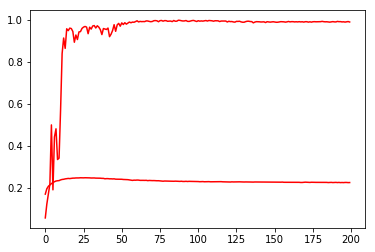

In [5]:
plt.figure()
plt.plot(range(len(curve_valid_acc)), curve_valid_acc, 'r-')
plt.show()